# Import Libraries and Setup
We import the necessary libraries and functions, set up the random seed for reproducibility, and define the paths for the data and model directories.

In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.linear_model import ElasticNet, BayesianRidge
from sklearn.svm import SVR

import sys
sys.path.append(os.path.abspath("../src"))  # Add the src directory to the system path
import importlib
import functions  # Import the updated functions module
importlib.reload(functions)  # Ensure the latest version is loaded

from functions import (
    build_pipeline, evaluate_model, select_features, tune_hyperparameters,
    save_model, visualize_results, load_model
)

# Set random seed for reproducibility
RANDOM_STATE = 42

# Load Data

We load the development and evaluation datasets, separate the features and target variables, and create the directories for saving the models.

In [2]:
# Load data
dev_df = pd.read_csv('../data/development_final_data.csv')
eval_df = pd.read_csv('../data/evaluation_final_data.csv')

# Separate features and target
X_dev, y_dev = dev_df.drop('bmi', axis=1), dev_df['bmi']
X_eval, y_eval = eval_df.drop('bmi', axis=1), eval_df['bmi']

# Directories for models
models_dir = '../models'
final_models_dir = '../final_models'
os.makedirs(models_dir, exist_ok=True)
os.makedirs(final_models_dir, exist_ok=True)

# Baseline Models

We train and evaluate the baseline models (ElasticNet, SVR, BayesianRidge) using default hyperparameters and all features. The evaluation results and statistics are printed, and the models are saved.

In [3]:
# 1. Baseline Models
baseline_results = {}
regressors = {
    'ElasticNet': ElasticNet(),
    'SVR': SVR(),
    'BayesianRidge': BayesianRidge()
}

for name, regressor in regressors.items():
    print(f"Training baseline {name}...")
    pipeline = build_pipeline(regressor)
    results_df, stats = evaluate_model(pipeline, X_dev, y_dev)
    baseline_results[name] = results_df
    print(f"Baseline {name} statistics:")
    for metric, values in stats.items():
        print(f"  {metric}:")
        print(f"    Mean: {values['mean']:.4f}")
        print(f"    Median: {values['median']:.4f}")
        print(f"    95% CI: ({values['95% CI'][0]:.4f}, {values['95% CI'][1]:.4f})")
    print()
    save_model(pipeline, f"{name}_baseline", models_dir)

Training baseline ElasticNet...
Baseline ElasticNet statistics:
  RMSE:
    Mean: 4.6922
    Median: 4.2226
    95% CI: (3.4809, 5.9035)
  MAE:
    Mean: 2.9094
    Median: 2.8386
    95% CI: (2.4286, 3.3901)
  R2:
    Mean: -0.3163
    Median: -0.0978
    95% CI: (-0.8365, 0.2039)

✅ Model saved: ../models/ElasticNet_baseline.joblib
Training baseline SVR...
Baseline SVR statistics:
  RMSE:
    Mean: 4.1830
    Median: 4.0412
    95% CI: (3.3507, 5.0152)
  MAE:
    Mean: 2.6857
    Median: 2.6365
    95% CI: (2.5632, 2.8081)
  R2:
    Mean: -0.0238
    Median: -0.0085
    95% CI: (-0.0704, 0.0228)

✅ Model saved: ../models/SVR_baseline.joblib
Training baseline BayesianRidge...
Baseline BayesianRidge statistics:
  RMSE:
    Mean: 4.1618
    Median: 4.0323
    95% CI: (3.2966, 5.0271)
  MAE:
    Mean: 2.7448
    Median: 2.7302
    95% CI: (2.6148, 2.8747)
  R2:
    Mean: -0.0111
    Median: -0.0011
    95% CI: (-0.0309, 0.0086)

✅ Model saved: ../models/BayesianRidge_baseline.joblib


# Feature Selection

We perform feature selection using RFE (or SelectKBest) to reduce the dimensionality of the dataset. The selected features are then used in subsequent steps.

In [4]:
# 2. Feature Selection
X_dev_selected, selected_features = select_features(X_dev, y_dev, method='rfe', k=50) # You can change rfe to 'selectkbest'
X_eval_selected = X_eval[selected_features]

✅ Selected features: ['alistipes_putredinis', 'anaerotruncus_colihominis', 'bacteroides_massiliensis', 'barnesiella_viscericola', 'bifidobacterium_bifidum', 'faecalibacterium_sp._mc_41', 'oscillibacter_valericigenes', 'pseudobacteroides_cellulosolvens', 'pseudoflavonifractor_capillosus', 'roseburia_hominis', 'roseburia_intestinalis', 'ruminiclostridium_thermocellum', 'ruminococcaceae_bacterium_d16', 'ruminococcus_albus', 'ruminococcus_callidus', 'ruminococcus_champanellensis', 'ruminococcus_flavefaciens', 'ruminococcus_sp._dsm_100440', 'sporobacter_termitidis', 'streptococcus_infantarius', 'streptococcus_mitis', 'streptococcus_oralis', 'sutterella_parvirubra', 'thermobaculum_terrenum', 'victivallis_sp._mc_44', 'bacteroides_pectinophilus', 'clostridium_aldenense', 'clostridium_asparagiforme', 'clostridium_bolteae', 'clostridium_celerecrescens', 'clostridium_cellobioparum', 'clostridium_clariflavum', 'clostridium_colinum', 'clostridium_indolis', 'clostridium_leptum', 'clostridium_methylp

# Models with Feature Selection

We train and evaluate the models using the selected features. The evaluation results and statistics are printed, and the models are saved.

In [5]:
# 3. Models with Feature Selection
fs_results = {}
for name, regressor in regressors.items():
    print(f"Training {name} with feature selection...")
    pipeline = build_pipeline(regressor, feature_selection='rfe', k=50) # or feature_selection='selectkbest'
    results_df, stats = evaluate_model(pipeline, X_dev_selected, y_dev)
    fs_results[name] = results_df
    print(f"FS {name} statistics:")
    for metric, values in stats.items():
        print(f"  {metric}:")
        print(f"    Mean: {values['mean']:.4f}")
        print(f"    Median: {values['median']:.4f}")
        print(f"    95% CI: ({values['95% CI'][0]:.4f}, {values['95% CI'][1]:.4f})")
    print()
    save_model(pipeline, f"{name}_fs", models_dir)

Training ElasticNet with feature selection...
FS ElasticNet statistics:
  RMSE:
    Mean: 4.3255
    Median: 3.9814
    95% CI: (3.4954, 5.1555)
  MAE:
    Mean: 2.7560
    Median: 2.7010
    95% CI: (2.4251, 3.0868)
  R2:
    Mean: -0.1073
    Median: 0.0196
    95% CI: (-0.3333, 0.1188)

✅ Model saved: ../models/ElasticNet_fs.joblib
Training SVR with feature selection...
FS SVR statistics:
  RMSE:
    Mean: 4.1671
    Median: 3.9975
    95% CI: (3.2925, 5.0417)
  MAE:
    Mean: 2.6535
    Median: 2.6321
    95% CI: (2.5461, 2.7609)
  R2:
    Mean: -0.0144
    Median: 0.0010
    95% CI: (-0.0628, 0.0341)

✅ Model saved: ../models/SVR_fs.joblib
Training BayesianRidge with feature selection...
FS BayesianRidge statistics:
  RMSE:
    Mean: 4.2785
    Median: 3.9534
    95% CI: (3.4103, 5.1468)
  MAE:
    Mean: 2.7617
    Median: 2.7209
    95% CI: (2.4998, 3.0235)
  R2:
    Mean: -0.0763
    Median: -0.0027
    95% CI: (-0.2442, 0.0916)

✅ Model saved: ../models/BayesianRidge_fs.joblib


# Hyperparameter Tuning

We perform hyperparameter tuning using GridSearchCV to find the best hyperparameters for each model. The tuned models are then trained and evaluated.

In [6]:
# 4. Hyperparameter Tuning
tuned_results = {}
param_grids = {
    'ElasticNet': {'regressor__alpha': [0.1, 1.0, 10.0], 'regressor__l1_ratio': [0.1, 0.5, 0.9]},
    'SVR': {'regressor__C': [0.1, 1, 10], 'regressor__epsilon': [0.1, 0.2, 0.5]},
    'BayesianRidge': {'regressor__alpha_1': [1e-6, 1e-5, 1e-4], 'regressor__alpha_2': [1e-6, 1e-5, 1e-4], 'regressor__lambda_1': [1e-6, 1e-5, 1e-4], 'regressor__lambda_2': [1e-6, 1e-5, 1e-4]}
}

for name, regressor in regressors.items():
    print(f"Tuning {name}...")
    pipeline = build_pipeline(regressor, feature_selection='rfe', k=50) # or feature_selection='selectkbest'
    best_model = tune_hyperparameters(X_dev_selected, y_dev, pipeline, param_grids[name])
    results_df, stats = evaluate_model(best_model, X_eval_selected, y_eval)
    tuned_results[name] = results_df
    print(f"Tuned {name} statistics:")
    for metric, values in stats.items():
        print(f"  {metric}:")
        print(f"    Mean: {values['mean']:.4f}")
        print(f"    Median: {values['median']:.4f}")
        print(f"    95% CI: ({values['95% CI'][0]:.4f}, {values['95% CI'][1]:.4f})")
    print()
    save_model(best_model, f"{name}_tuned", models_dir)

Tuning ElasticNet...
🔍 Starting hyperparameter tuning...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/root/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.188e+01, tolerance: 7.487e-01
  model = cd_fast.enet_coordinate_descent(
/root/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.966e+00, tolerance: 7.487e-01
  model = cd_fast.enet_coordinate_descent(


✅ Best hyperparameters: {'regressor__alpha': 10.0, 'regressor__l1_ratio': 0.9}
✅ Best RMSE: 4.147828891726197
Tuned ElasticNet statistics:
  RMSE:
    Mean: 3.9186
    Median: 3.9798
    95% CI: (3.2968, 4.5404)
  MAE:
    Mean: 2.8612
    Median: 2.7270
    95% CI: (2.5252, 3.1973)
  R2:
    Mean: 0.0117
    Median: -0.0001
    95% CI: (-0.0254, 0.0487)

✅ Model saved: ../models/ElasticNet_tuned.joblib
Tuning SVR...
🔍 Starting hyperparameter tuning...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
✅ Best hyperparameters: {'regressor__C': 0.1, 'regressor__epsilon': 0.5}
✅ Best RMSE: 4.146723321155674
Tuned SVR statistics:
  RMSE:
    Mean: 3.9754
    Median: 4.1025
    95% CI: (3.4162, 4.5345)
  MAE:
    Mean: 2.8530
    Median: 2.7830
    95% CI: (2.5305, 3.1755)
  R2:
    Mean: -0.0197
    Median: -0.0197
    95% CI: (-0.0466, 0.0072)

✅ Model saved: ../models/SVR_tuned.joblib
Tuning BayesianRidge...
🔍 Starting hyperparameter tuning...
Fitting 5 folds for each of 81 cand

# Visualization

We visualize the evaluation results using boxplots to compare the performance of the models at different stages (baseline, feature selection, tuned).

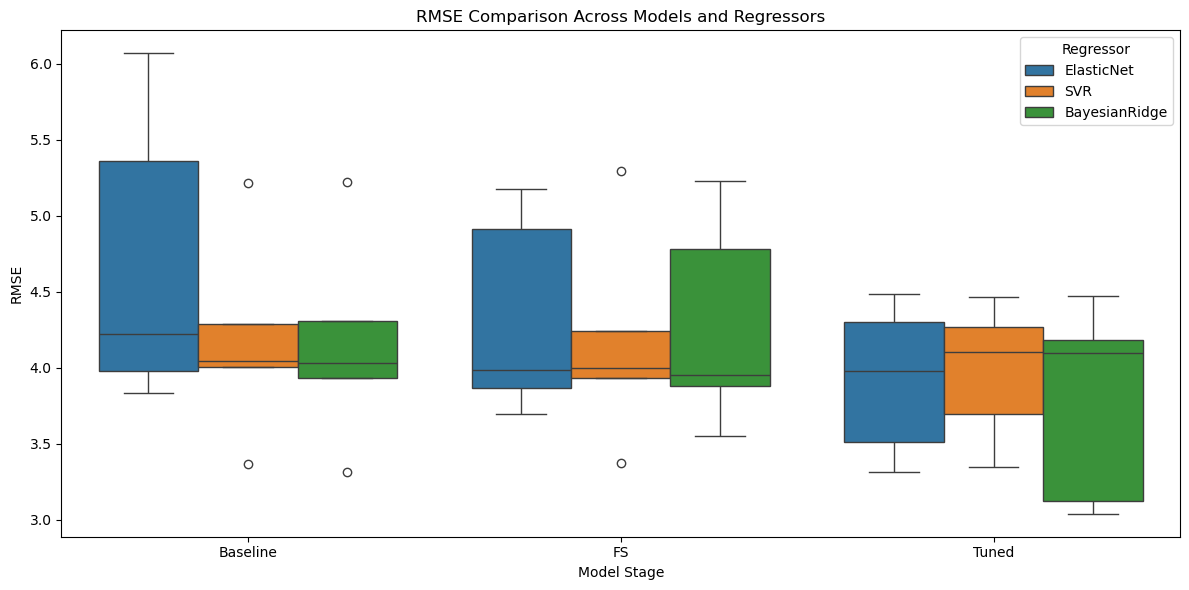

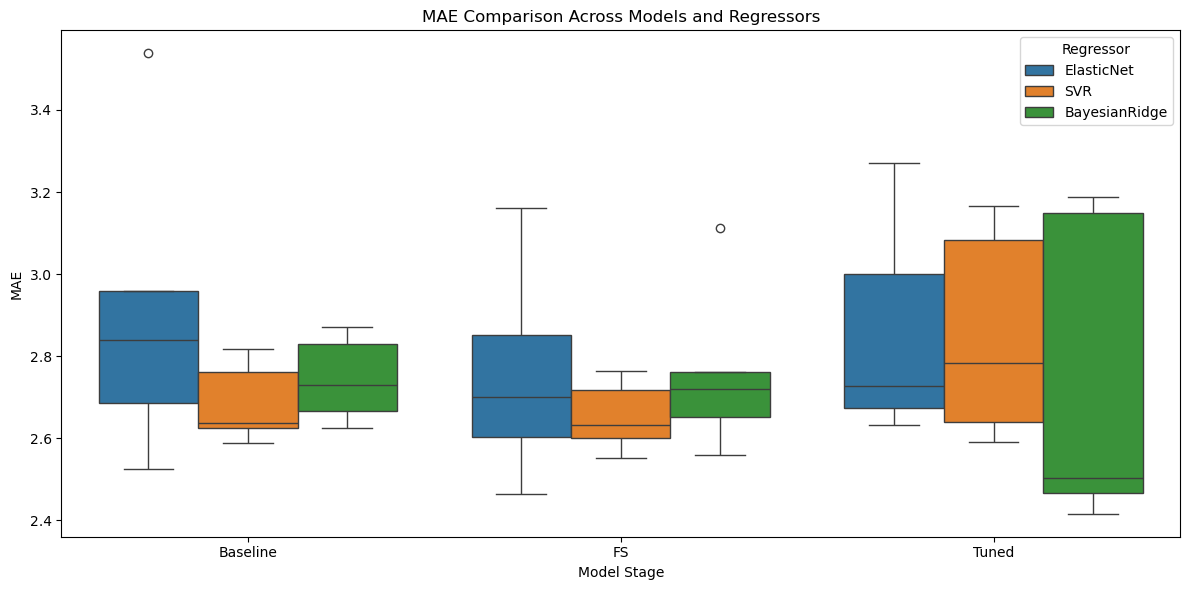

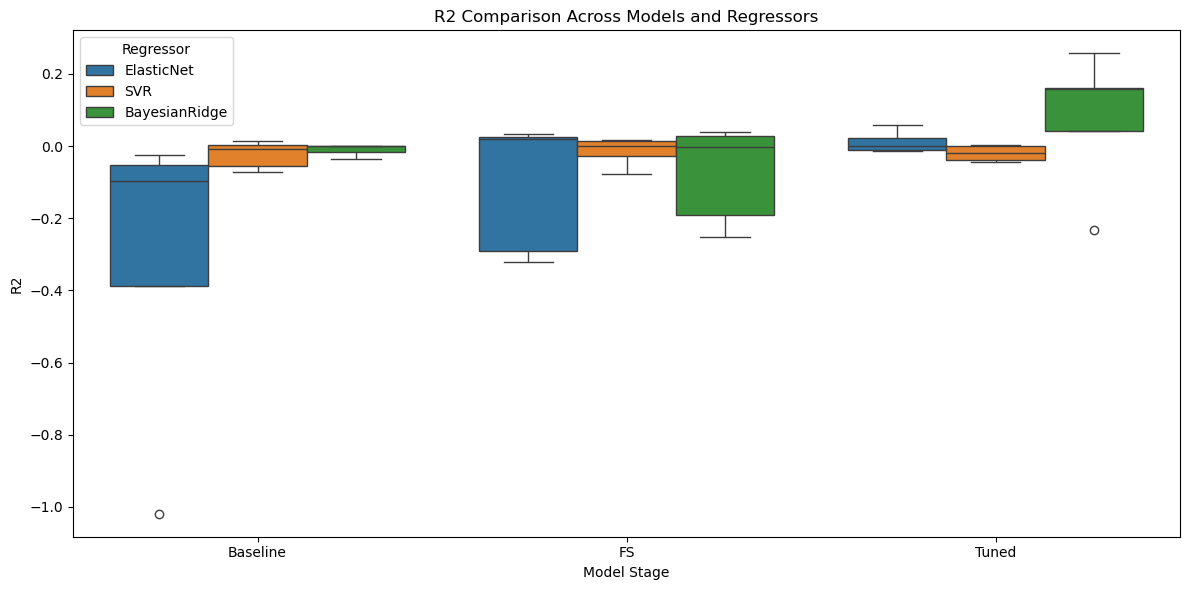

In [7]:
# 5. Visualization
visualize_results({
    'Baseline': baseline_results,
    'FS': fs_results,
    'Tuned': tuned_results
})

# Final Models and Comparison

We load the best tuned models for each regressor from the `models` directory, evaluate their performance on the evaluation set, and save them in the `final_models` directory. We then compare the models based on their RMSE to determine the best overall model.

In [8]:
# 6. Final Models and Comparison
final_models = {}

for name, regressor in regressors.items():
    print(f"Loading tuned {name}...")
    final_pipeline = load_model(f'{models_dir}/{name}_tuned.joblib')
    final_models[name] = final_pipeline
    save_model(final_pipeline, name, final_models_dir)

# Evaluate the final models
final_results = {}
for name, model in final_models.items():
    results_df, stats = evaluate_model(model, X_eval_selected, y_eval)
    final_results[name] = stats

    # Print model details
    print(f"\nFinal {name} details:")
    print("  Best hyperparameters:")
    for key, value in model.named_steps['regressor'].get_params().items():
        print(f"    {key}: {value}")
    print(f"  Selected features: {', '.join(selected_features)}")
    print("  Evaluation results:")
    for metric, values in stats.items():
        print(f"    {metric}:")
        print(f"      Mean: {values['mean']:.4f}")
        print(f"      Median: {values['median']:.4f}")
        print(f"      95% CI: ({values['95% CI'][0]:.4f}, {values['95% CI'][1]:.4f})")

# Compare final models and declare the best
print("\nComparing final models:")
best_model_name = None
best_rmse = float('inf')
for name, stats in final_results.items():
    rmse = stats['RMSE']['mean']
    print(f"  {name}: RMSE = {rmse:.4f}")
    if rmse < best_rmse:
        best_rmse = rmse
        best_model_name = name

print(f"\nBest model: {best_model_name}")

Loading tuned ElasticNet...
✅ Model saved: ../final_models/ElasticNet.joblib
Loading tuned SVR...
✅ Model saved: ../final_models/SVR.joblib
Loading tuned BayesianRidge...
✅ Model saved: ../final_models/BayesianRidge.joblib

Final ElasticNet details:
  Best hyperparameters:
    alpha: 10.0
    copy_X: True
    fit_intercept: True
    l1_ratio: 0.9
    max_iter: 1000
    positive: False
    precompute: False
    random_state: None
    selection: cyclic
    tol: 0.0001
    warm_start: False
  Selected features: alistipes_putredinis, anaerotruncus_colihominis, bacteroides_massiliensis, barnesiella_viscericola, bifidobacterium_bifidum, faecalibacterium_sp._mc_41, oscillibacter_valericigenes, pseudobacteroides_cellulosolvens, pseudoflavonifractor_capillosus, roseburia_hominis, roseburia_intestinalis, ruminiclostridium_thermocellum, ruminococcaceae_bacterium_d16, ruminococcus_albus, ruminococcus_callidus, ruminococcus_champanellensis, ruminococcus_flavefaciens, ruminococcus_sp._dsm_100440, sp

# Winner Model

Based on the comparison in the previous step, we train the best performing model (the "winner") on the combined development and evaluation datasets to maximize the amount of training data. This final "winner" model is then saved in the `final_models` directory with the name "winner". This model will be used for final evaluation on an unseen holdout set.

In [9]:
# 7. Winner Model
winner_model = final_models[best_model_name]
winner_model.fit(pd.concat([X_dev_selected, X_eval_selected]), pd.concat([y_dev, y_eval]))
save_model(winner_model, 'winner', final_models_dir)

print('✅ Notebook finished.')

✅ Model saved: ../final_models/winner.joblib
✅ Notebook finished.
